In [98]:
%matplotlib inline

from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import binarize
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

import numpy as np
import scipy as sp
import scipy.io as sio

import h5py

import seaborn as sns
import matplotlib.pyplot as plt

import pickle

In [104]:
def save_obj(obj, name):
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name, 'rb') as f:
        return pickle.load(f)

# Definining DeepSea model

DeepSEA model is adapted from the paper published by Olga lab in Princeton.  
3x covolution layers (with maxpooling and ReLu activations) and 2x dense layers.  
The network is regularized by dropout as well as L2 on convolution layers and L1 on dense layers.

In [2]:
def DeepSEA():
    nkernels = [320,480,960]
    in_size = (1,1000,4)
    l2_lam = 5e-07 
    l1_lam = 1e-08 

    model = Sequential()
    model.add(Conv2D(nkernels[0], kernel_size=(1,8), strides=(1,1), padding='same', input_shape=in_size, kernel_regularizer=regularizers.l2(l2_lam)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(1,4), strides=(1,4)))
    model.add(Dropout(0.2))
    
    #expecting 
    #(4,250,320) here

    model.add(Conv2D(nkernels[1], kernel_size=(1,8), strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(l2_lam)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(1,4), strides=(1,4)))
    model.add(Dropout(0.2))

    model.add(Conv2D(nkernels[1], kernel_size=(1,8), strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(l2_lam)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(919, kernel_regularizer=regularizers.l1(l1_lam)))
    model.add(Activation('relu'))
    model.add(Dense(919, kernel_regularizer=regularizers.l1(l1_lam)))
    model.add(Activation('sigmoid'))
    
    return model

# Loading Data


Input data is 1000bp one hot encoded DNA sequence alinged to hg19 reference genome. It is empirically validated that at least one of the 919 genomic features are map to the 1000 bp window. See DeepSea paper from Princeton for the details.

Sample size
- 4400000 for training
- 8000 for validation
- 450000 for testing 

In [3]:
valid = sio.loadmat("../deepsea_train/valid.mat")
train = h5py.File("../deepsea_train/train.mat")
test = sio.loadmat("../deepsea_train/test.mat")

In [4]:
valid_X = valid["validxdata"]
valid_X = np.expand_dims(valid_X, 3)
valid_X = np.transpose(valid_X, axes=(0,3,2,1))
valid_Y = valid["validdata"]

In [5]:
train_X = train["trainxdata"][()]
train_X = np.expand_dims(train_X, 3)
train_X = np.transpose(train_X, axes=(2,1,0,3))
train_X = np.transpose(train_X, axes=(0,3,2,1))
train_Y = np.transpose(train["traindata"][()])

In [6]:
test_X = test["testxdata"]
test_X = np.expand_dims(test_X, 3)
test_X = np.transpose(test_X, axes=(0,3,2,1))
test_Y = test["testdata"]

# Training DeepSea

We are using adaptive momentum as a optimizer.   
The binary_crossentropy loss for multi-label problem is equivalent to negative log likelihood metioned in the original paper.

The model was trained for 10 epochs

In [24]:
model = DeepSEA()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [26]:
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}-full.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
result = model.fit(train_X, train_Y,
          epochs=10, batch_size=256,
          callbacks=callbacks_list,
          initial_epoch=5, 
          validation_data=(valid_X, valid_Y))

Train on 4400000 samples, validate on 8000 samples
Epoch 6/10
  16896/4400000 [..............................] - ETA: 14047s - loss: 0.0675 - acc: 0.9800

In [92]:
save_obj(result.history, "history_run01_epoch05-09.pkl")

In [109]:
def load_result(files):
    labels = ["acc", "loss", "val_loss", "val_acc"]
    ret = {"acc":[], "loss":[], "val_loss":[], "val_acc":[],}
    for path in files:
        result = load_obj(path)
        for l in labels:
            ret[l] = ret[l] + result[l]
    return ret

In [113]:
result = load_result(["history_run01_epoch00-04.pkl", "history_run01_epoch05-09.pkl"])

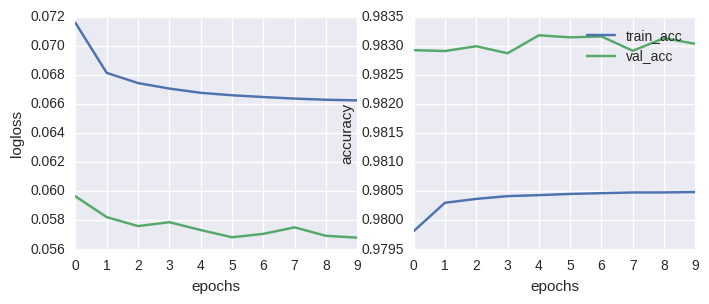

In [118]:
fig = plt.figure(figsize=(8,3))
plt.subplot("121")
plt.plot(range(len(result["loss"])), result["loss"], label="train_loss")
plt.plot(range(len(result["val_loss"])), result["val_loss"], label="val_loss")
plt.xlabel("epochs")
plt.ylabel("logloss")

plt.subplot("122")
plt.plot(range(len(result["acc"])), result["acc"], label="train_acc")
plt.plot(range(len(result["val_acc"])), result["val_acc"], label="val_acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

In [85]:
prediction = model.predict(test_X)

# Visualizing result (after 10 epochs)

The result was validated by measuring area under ROC curve for each genomic feature.  
The values were compared against the result from DeepSEA paper to check the consistenty.


In [135]:
deepsea_result = [i.rstrip().split("\t") for i in open("features.txt", "r").readlines()][1:-1]

In [148]:
result1 = []
for i in range(test_Y.shape[1]):
    try:
        result1.append(roc_auc_score(test_Y[:,i], prediction[:,i]))
    except:
        result1.append(0)

In [146]:
result2 = []
for i in deepsea_result:
    try:
        result2.append(float(i[4]))
    except:
        result2.append(0)

The drop in the performance likely comes from insufficient training time.

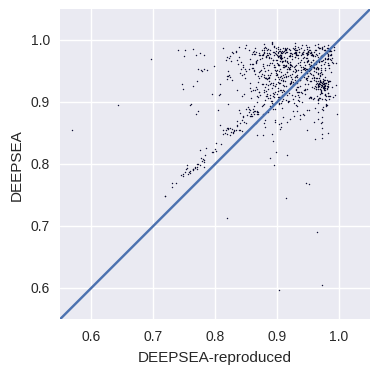

In [161]:
plt.figure(figsize=(4, 4))
plt.scatter(result1, result2, s=0.5)
plt.xlim(0.55, 1.05)
plt.ylim(0.55, 1.05)
plt.plot([0,1.05],[0,1.05])
plt.ylabel("DEEPSEA")
plt.xlabel("DEEPSEA-reproduced")

In [86]:
start = 500
end = 1000
num_start = 100
num_end = 300

The figures below are randomly selelcted portion of truth and preidction matrix, correspoidng to 500 samples form 200 genomic features. You can see that there is clear pattern learned by neural nets.

Truth matrix

([], <a list of 0 Text xticklabel objects>)

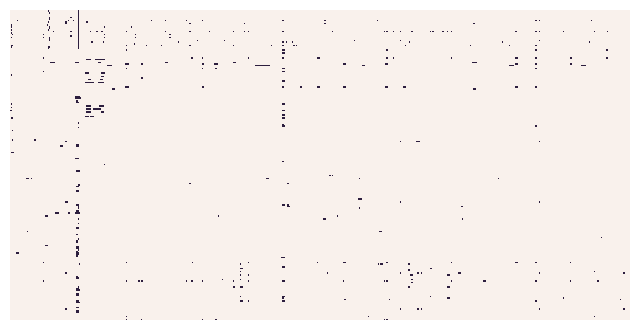

In [119]:
plt.figure(figsize=(8,4))
sns.heatmap(np.transpose(test_Y[start:end, num_start:num_end]), cbar=False)
plt.yticks([],[])
plt.xticks([],[])

Predicted matrix

([], <a list of 0 Text xticklabel objects>)

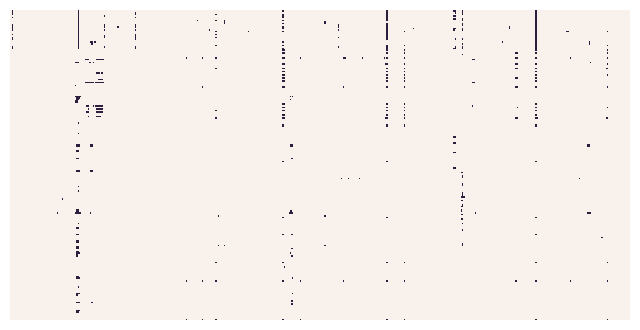

In [121]:
plt.figure(figsize=(8,4))
sns.heatmap(np.transpose(binarize(prediction[start:end, num_start:num_end], threshold=0.3)), cbar=False)
plt.yticks([],[])
plt.xticks([],[])